In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image
import cv2

from DLP_GradCam import GradCAM
%matplotlib inline

### Download the Model
We apply a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [2]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 62.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224).

First convolution layer with maxpool.
Then 4 ResNet blocks.

Output of the last ResNet block is of size (512x7x7).

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [5]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/"
dataset = preprocess_image(dir_path)

--2024-02-08 15:12:26--  https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477062 (1.4M) [application/zip]
Saving to: ‘TP2_images.zip’

TP2_images.zip      100%[===================>]   1.41M  1.08MB/s    in 1.3s    

2024-02-08 15:12:29 (1.08 MB/s) - ‘TP2_images.zip’ saved [1477062/1477062]

Archive:  TP2_images.zip
   creating: .ipynb_checkpoints/
  inflating: 155881293_721e90b57d.jpg  
  inflating: 158850087_3251644046.jpg  
  inflating: 1624593475_146bf1f7ff.jpg  
  inflating: 181748579_01a4611736.jpg  
  inflating: 2068921624_ef0986de13.jpg  
  inflating: 2637374064_fab14ec0b8.jpg  
  inflating: 2749465889_8e62023674.jpg  
  inflating: 2936812850_23bf0d1cfd.jpg  
  inflating: 3532471222_a6d7e3780e.jpg  
  inflating: 3633913271_ee789a3bc4.jpg  
  inflating: 3633949157_f577605ea9.jpg  
  infla

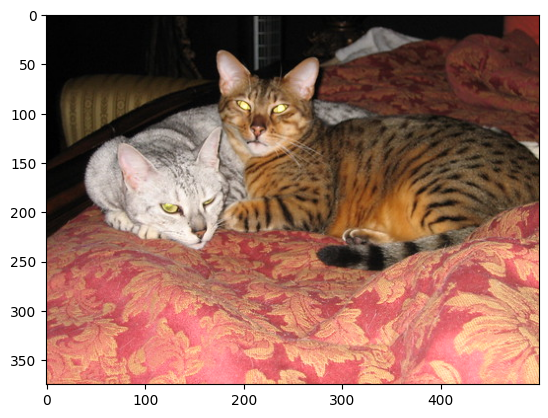

In [6]:
# show the orignal image
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [7]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.175314 11.065537 10.584748]


### Grad-CAM
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).For each image, choose the top-3 possible labels as the desired classes.

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | -
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [8]:
def visualize_with_gradcam(model, dataset, index, target_layer):
    grad_cam = GradCAM(model, target_layer)

    input_tensor, _ = dataset[index]
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

    original_image = Image.open(dataset.imgs[index][0]).convert('RGB')
    original_image = np.array(original_image)

    output = model(input_tensor)
    values, indices = torch.topk(output, 3)


    for class_idx in indices[0].numpy():
        heatmap = grad_cam(input_tensor, class_idx)

        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        heatmap = 1- heatmap

        # Resize the heatmap to the size of the original image
        heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

        # Convert heatmap to RGB
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose the heatmap on original image
        superimposed_img = heatmap * 0.5 + original_image

        # Display the original image with heatmap overlay
        plt.figure()
        plt.imshow(superimposed_img / 255) # Correct the scale to display properly with plt.imshow
        plt.title(f"Class: {classes[class_idx]}")
        plt.show()

In [9]:
target_layer = 'layer4'
index = 5

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


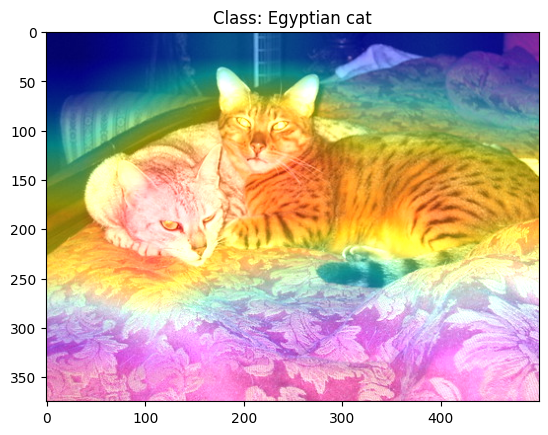

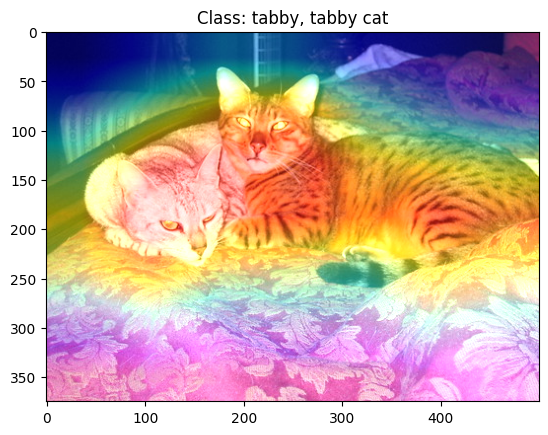

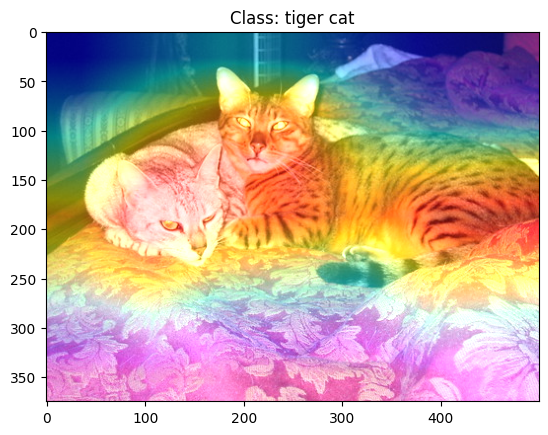

In [10]:
visualize_with_gradcam(resnet34, dataset, index, target_layer)